In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob

## Visualization part

In [2]:
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap = cmap_type)
    plt.title(title)

## Read an Image

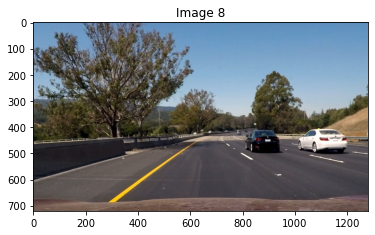

In [3]:
# Reading an image
images_paths = glob.glob("media/test_images/*.jpg")
images = [plt.imread(image) for image in images_paths]

# getting img dimensions and printing it
image_idx = 7

show_image(images[image_idx], "Image " + str(image_idx + 1))

## Read a Video

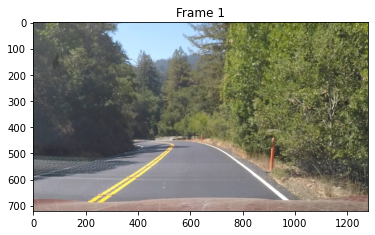

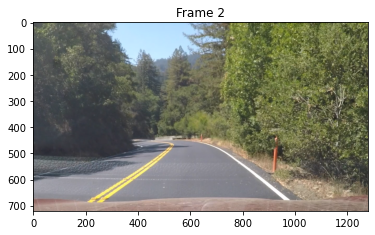

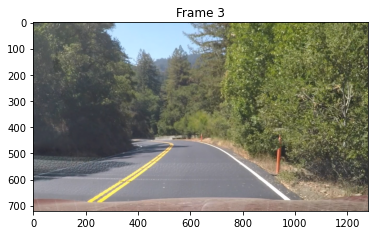

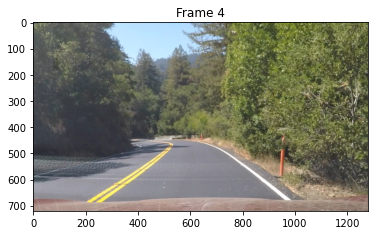

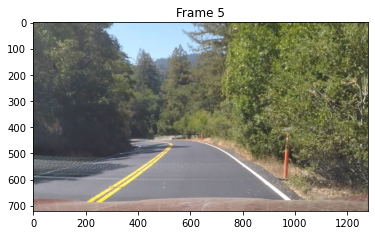

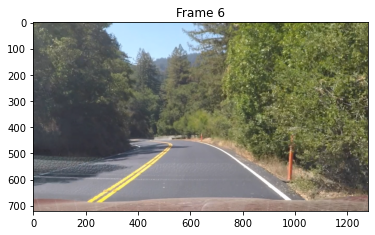

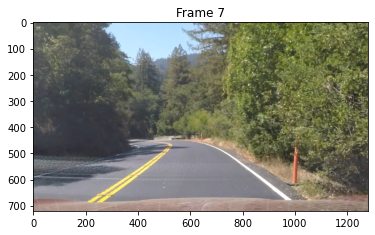

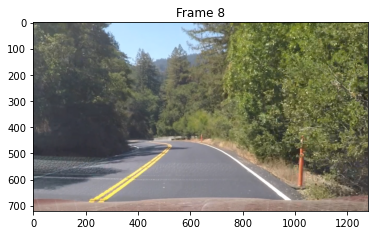

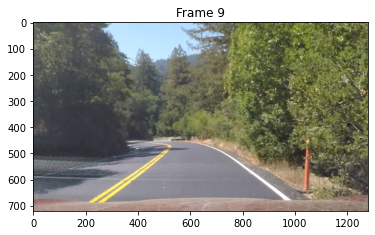

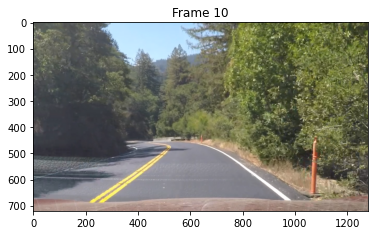

In [4]:
VideoFlag = True

if (VideoFlag):
    video_paths = glob.glob("media/*.mp4")
    videos = [cv2.VideoCapture(video) for video in video_paths]

    video_idx = 1
    framePerSecond = int(videos[video_idx].get(cv2.CAP_PROP_FPS))
    frameCount = int(videos[video_idx].get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(videos[video_idx].get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(videos[video_idx].get(cv2.CAP_PROP_FRAME_HEIGHT))
        
    frames = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))


    plt.rcParams['figure.max_open_warning'] = frameCount

    fc = 0
    ret = True


    while (fc < frameCount  and ret):
        ret, frames[fc] = videos[video_idx].read()
        fc += 1

    videos[video_idx].release()

    #columns = 4
    limit = 10

    #px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    #plt.subplots(figsize=(600*px, 200*px))
    # for i, frame in enumerate(frames[:limit]):
    #     plt.subplot(len(frames[:limit])// columns + 1, columns, i + 1)
    #     show_image(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB), "Frame " + str(i+1))

    for i, frame in enumerate(frames[:limit]):
        plt.figure()
        show_image(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), "Frame "+ str(i+1))

    #show_image(cv2.cvtColor(frames[1], cv2.COLOR_BGR2RGB), "Frame 2")


## Pipeline Start

In [5]:
### Apply gaussian blue to eliminate noise
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [6]:
def canny(image):    
    # canny to find edges
    #derivative small deriv small change big deriv is an edge
    canny_img = cv2.Canny(image, 50, 150)
    return canny_img

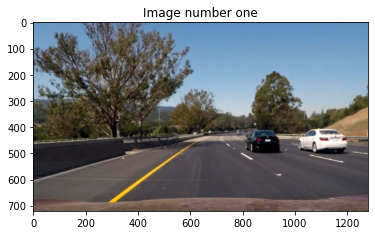

In [7]:
# so that changes are done to the copy
lane_img=np.copy(images[image_idx])

blur_img = gaussian_blur(lane_img, 5)
show_image(blur_img, "Image number one")

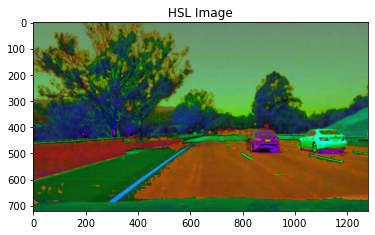

In [8]:
#making the image hls to reduce processing time

hls_img = cv2.cvtColor(blur_img, cv2.COLOR_RGB2HLS)
h_channel = hls_img[:, :, 0]
l_channel = hls_img[:, :, 1]
s_channel = hls_img[:, :, 2]

show_image(hls_img, "HSL Image")

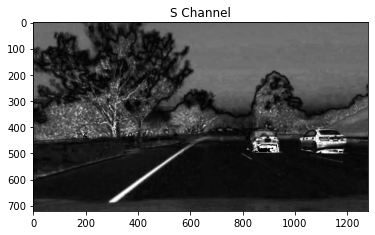

In [9]:
show_image(s_channel, "S Channel")

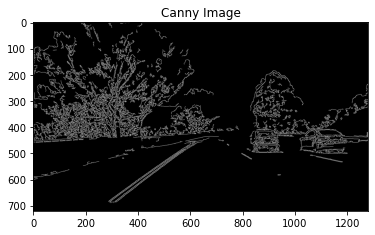

In [10]:
canny_img = canny(s_channel)
show_image(canny_img, "Canny Image")

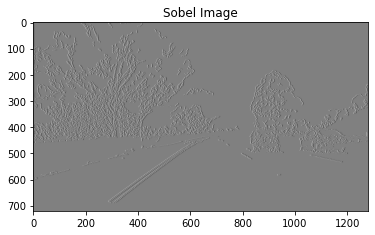

In [11]:
sobelx = cv2.Sobel(canny_img, cv2.CV_64F, 1, 0)
show_image(sobelx, "Sobel Image")

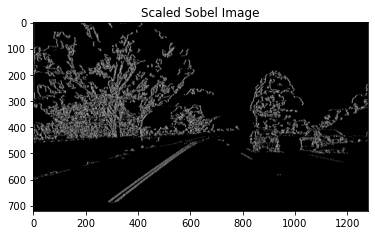

In [12]:
abs_sobel_x = np.absolute(sobelx)
scaled_sobel = (255 * ((abs_sobel_x) / np.max(abs_sobel_x))).astype(np.uint8)
#print((scaled_sobel.dtype))
show_image(scaled_sobel, "Scaled Sobel Image")

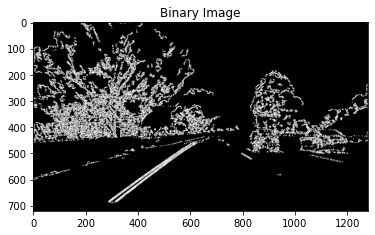

In [13]:
sx_thresh = [20, 200]

sx_binary = np.zeros_like(scaled_sobel)
sx_binary[(scaled_sobel > sx_thresh[0]) & (scaled_sobel < sx_thresh[1])] = 1
show_image(sx_binary, "Binary Image")

In [14]:
def getPolyPoints(image, maxLaneWidth,minLaneWidth,goAbove):
        
    height, width = image.shape[:2]
    
    # Points = (LeftLineStart,RightLineStart,LeftLineEnd,RightLineEnd)
    Points = [(-1,-1),(-1,-1),(-1,-1),(-1,-1)]
    
    AllPointsLeft = []
    AllPointsRight = []
    
    i = height-1
    limit = 500
   
    leftFound = False # found left lane pixel in this height
    RightFound = False # found right lane pixel in this height
    endMet = False # reached minimum lane or less
    
    while ((i > limit) and ((Points[0][0] == -1) or (Points[1][0] == -1) or (not endMet))):
        leftFound = False
        RightFound = False
        for j in range(maxLaneWidth//2):
            if ((image[i,((width//2) -1) - j] == 1) and (not leftFound)) :
                if(Points[0][0] == -1): # or (Points[1][0] == -1):
                    Points[0] = (((width//2) -1) - j,i)
                    #print(i, ((width//2) -1) - j, Points[0], Points[1])
                AllPointsLeft.append((((width//2) -1) - j,i))
                Points[2] = (((width//2) -1) - j,i)
                leftFound = True
                
            if ((image[i,((width//2) -1) + j] == 1) and (not RightFound)):
                if(Points[1][0] == -1): #or (Points[0][0] == -1):
                    Points[1] = (((width//2) -1) + j,i)
                    #print(i, ((width//2) -1) + j, Points[0], Points[1])
                AllPointsRight.append((((width//2) -1) + j,i))
                Points[3] = (((width//2) -1) + j,i)
                RightFound = True
            
            if ((np.absolute(Points[2][0] - Points[3][0]) < minLaneWidth) 
                and ((Points[0][0] != -1) and (Points[1][0] != -1))):
                endMet = True
        i -=1
    print(Points)
    #AvgEndPoint = ((Points[2][0] + Points[3][0]) //2 , Points[2][1]-goAbove)
    #return np.array([[Points[0], Points[1],AvgEndPoint]])
    return Points, AllPointsLeft , AllPointsRight

In [15]:
getPolyPoints(sx_binary,900,200,80)[0]

[(310, 689), (934, 584), (565, 501), (797, 501)]


[(310, 689), (934, 584), (565, 501), (797, 501)]

In [16]:
def generateEmptyImage(height,width):
    return np.zeros((height,width,3), dtype=np.uint8)

In [17]:
def DrawLines (Points , height, width):
    
    # Generate Blank Image
    image = generateEmptyImage(height, width)
    
    linesColor = (255, 0, 0)
    linesThickness = 10
    
    # newPoints = (LeftLineStart,RightLineStart,LeftLineEnd,RightLineEnd)
    newPoints = [(),(),(),()]
    
    # extend the line from the start
    if (Points[0][1] != Points[1][1]):
        #different start
        if (Points[0][1] < Points[1][1]) :
            # Extend Left
            slope= (Points[0][1] - Points[2][1]) / (Points[0][0] - Points[2][0])
            # slope = (y2 - y1) / (x2 - x1) ---> solve for x2 then x2 = (y2 - y1/ slope) + x1
            NewX = int(((Points[1][1]-Points[0][1])// slope) + Points[0][0])
            newPoints[0] = (NewX,Points[1][1])
            newPoints[1] = Points[1]
            #cv2.line(image, (NewX,Points[1][1]), Points[2], linesColor, thickness=linesThickness)
            #cv2.line(image, Points[1], Points[3], linesColor, thickness=linesThickness)
        else :
            # Extend Right
            slope= (Points[1][1] - Points[3][1]) / (Points[1][0] - Points[3][0])
            # slope = (y2 - y1) / (x2 - x1) ---> solve for x2 then x2 = (y2 - y1/ slope) + x1
            NewX = int(((Points[0][1]-Points[1][1])/ slope) + Points[1][0])
            newPoints[0] = Points[0]
            newPoints[1] = (NewX,Points[0][1])
            #cv2.line(image, (NewX,Points[0][1]), Points[3], linesColor, thickness=linesThickness)
            #cv2.line(image, Points[0], Points[2], linesColor, thickness=linesThickness)
    else:
        newPoints[0] = Points[0]
        newPoints[1] = Points[1]
    
    # extend the line from the start
    if (Points[2][1] != Points[3][1]):
        #different end
        if (Points[2][1] > Points[3][1]) :
            # Extend Left
            slope= (Points[0][1] - Points[2][1]) / (Points[0][0] - Points[2][0])
            # slope = (y2 - y1) / (x2 - x1) ---> solve for x2 then x2 = (y2 - y1/ slope) + x1
            NewX = int(((Points[3][1]-Points[0][1])// slope) + Points[0][0])
            newPoints[2] = (NewX,Points[3][1])
            newPoints[3] = Points[3]
        else :
            # Extend Right
            slope= (Points[1][1] - Points[3][1]) / (Points[1][0] - Points[3][0])
            # slope = (y2 - y1) / (x2 - x1) ---> solve for x2 then x2 = (y2 - y1/ slope) + x1
            NewX = int(((Points[2][1]-Points[1][1])/ slope) + Points[1][0])
            newPoints[2] = Points[2]
            newPoints[3] = (NewX,Points[2][1])
    else:
        newPoints[2] = Points[2]
        newPoints[3] = Points[3]
    
    print(newPoints)
    cv2.line(image, newPoints[0], newPoints[2], linesColor, thickness=linesThickness)
    cv2.line(image, newPoints[1], newPoints[3], linesColor, thickness=linesThickness)

    return image , newPoints

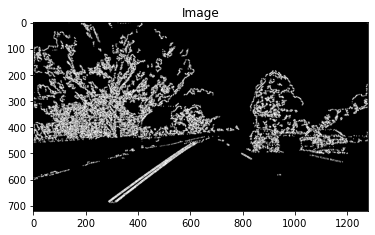

In [18]:
show_image(sx_binary)

[(310, 689), (934, 584), (565, 501), (797, 501)]
[(310, 689), (1107, 689), (565, 501), (797, 501)]


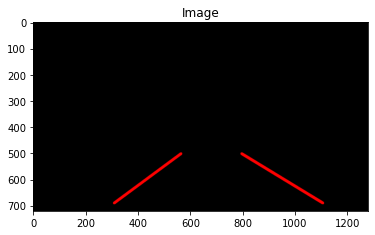

In [19]:
Points , AllPointsLeft, AllPointsRight = getPolyPoints(sx_binary,850,120,80)

LanesDrawn, newPoints = DrawLines(Points,sx_binary.shape[0],sx_binary.shape[1])
show_image(LanesDrawn)

In [20]:
# AdjustPoints(LeftLineStart,LeftLineEnd,RightLineEnd,RightLineStart,)
AdjustedPoints = np.array([(newPoints[0]),(newPoints[2]),(newPoints[3]),(newPoints[1])])
print(AdjustedPoints)

[[ 310  689]
 [ 565  501]
 [ 797  501]
 [1107  689]]


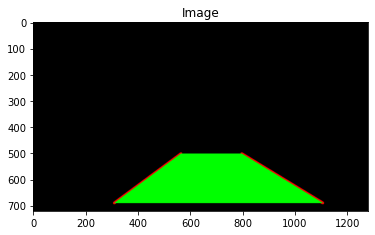

In [21]:
cv2.fillPoly(LanesDrawn, pts = [AdjustedPoints] ,color=(0, 255, 0))
show_image(LanesDrawn)

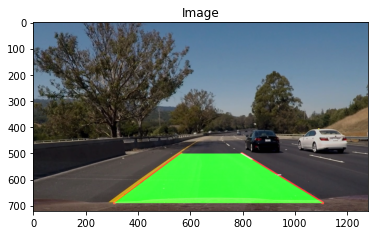

In [22]:
combine = cv2.addWeighted(images[image_idx],0.8, LanesDrawn, 1,1)
show_image(combine)

In [23]:
def getXYPoints(PointsArr):
    x,y = np.hsplit(PointsArr,2)
    x = np.transpose(x)[0]
    y = np.transpose(y)[0]
    return x ,y

In [24]:
AdjustedLeftPoints = np.array(AllPointsLeft)
AdjustedRightPoints = np.array(AllPointsRight)
LeftX , LeftY = getXYPoints(AdjustedLeftPoints)
RightX , RightY = getXYPoints(AdjustedRightPoints)

# with np.printoptions(threshold=np.inf):
#     print(AdjustedLeftPoints)


In [25]:
def getListInRange(minRange,maxRange):
    List = []
    for i in range(maxRange -minRange + 1):
        List.append(minRange + i)
    return List

In [26]:
def getMedianHeightfilter(Points,xPoints,yPoints,numPoints):
    newPoints= []
    newxPoints = np.copy(xPoints)
    newyPoints = np.copy(yPoints)
    for i in range(len(Points)):
        if ((i - numPoints//2)  <0): # At start and need padding --> take numPoints from right
            #newPoints.append((xPoints[i],(np.median(yPoints[0:numPoints]))))
            newxPoints[i] = (np.median(newxPoints[0:numPoints]))
            newPoints.append((newxPoints[i],newyPoints[i]))
    
        else:
            newxPoints[i] = (np.median(xPoints[(i - (numPoints//2)):(i + (numPoints//2) + 1)]))
            newPoints.append((newxPoints[i],newyPoints[i]))
            #newPoints.append((xPoints[i],(np.median(yPoints[((i+1) - numPoints//2):((i+1) + numPoints//2)]))))
            
    #newxPoints, newyPoints = getXYPoints(Points)
    return newPoints,newxPoints,newyPoints

(698.4, 491.6)

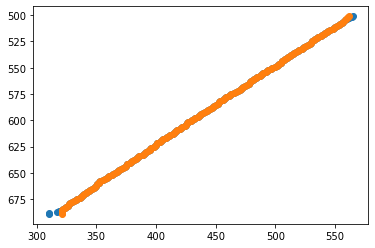

In [27]:
## After median Graph
NewAdjustedLeftPoints, NewLeftX,NewLeftY = getMedianHeightfilter(AdjustedLeftPoints,LeftX,LeftY,9)
plt.scatter(LeftX,LeftY)
plt.scatter(NewLeftX, NewLeftY)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])

(588.15, 496.85)

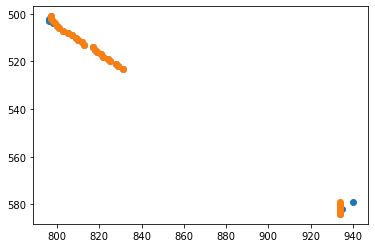

In [28]:
## After median Graph
NewAdjustedRightPoints, NewRightX,NewRightY = getMedianHeightfilter(AdjustedRightPoints,RightX,RightY,9)
plt.scatter(RightX, RightY)
plt.scatter(NewRightX, NewRightY)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])

In [29]:
# with np.printoptions(threshold=np.inf):
#     print(AdjustedLeftPoints)

In [30]:
# with np.printoptions(threshold=np.inf):
#     print(np.array(NewAdjustedLeftPoints))

In [31]:
def getPointsCurve(x,y,StartPoint, EndPoint):

    #ploty = np.linspace(EndPoint[1], StartPoint[1], StartPoint[1] - EndPoint[1]).astype(np.uint32)

    fit = np.polyfit(y, x, 2)
    a = fit[0]
    b = fit[1]
    c = fit[2]
    
    NewY = np.array(getListInRange(EndPoint[1],StartPoint[1]))#.astype(np.float64)
    #fit_equation = (a * np.square(y) + b * y + c).astype(np.uint16)
    fit_equation = (a * np.square(NewY) + b * NewY + c).astype(np.uint16)

#     maxy = max(maxy, np.max(y))
#     miny = min(miny, np.min(y))
#     plt.scatter(x, y)
#     ax = plt.gca()
#     ax.set_ylim(ax.get_ylim()[::-1])
#     plt.plot(x, y, 'o', label="Raw")
#     plt.plot(fit_equation, y,label="Fit to Raw")
#     return fit_equation , ploty
    NewPoints = np.dstack((fit_equation,NewY))
    return NewPoints

In [32]:
def DrawCurves(PointsLeft, PointsRight, height, width):
    
    # Generate Blank Image
    image = generateEmptyImage(height, width)
  
    isClosed = False
  
    color = (255, 0, 0)

    thickness = 10

    # Using cv2.polylines() method
    image = cv2.polylines(image, [PointsLeft], isClosed, color, thickness)
    image = cv2.polylines(image, [PointsRight], isClosed, color, thickness)
    return image

In [33]:
# # Visualization
# test_img=np.copy(images[image_idx])

# LeftPointsCurve, ploty = getPointsCurve(LeftX,LeftY,AdjustedPoints[0],AdjustedPoints[1])
# RightPointsCurve, ploty = getPointsCurve(RightX,RightY,AdjustedPoints[2],AdjustedPoints[3])
# for i, y in enumerate(ploty):
#     l = int(LeftPointsCurve[i])
#     r = int(RightPointsCurve[i])
#     y = int(y)
#     cv2.line(test_img, (l, y), (r, y), (0, 255, 0))
# show_image(test_img)

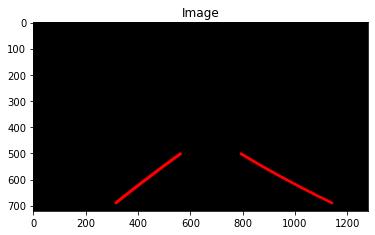

In [34]:
# LeftPointsCurve = getPointsCurve(LeftX,LeftY,AdjustedPoints[0],AdjustedPoints[1])
# RightPointsCurve = getPointsCurve(RightX,RightY,AdjustedPoints[3],AdjustedPoints[2])
LeftPointsCurve = getPointsCurve(NewLeftX,NewLeftY,AdjustedPoints[0],AdjustedPoints[1])
RightPointsCurve = getPointsCurve(NewRightX,NewRightY,AdjustedPoints[3],AdjustedPoints[2])
LanesDrawn2 = DrawCurves(LeftPointsCurve,RightPointsCurve,sx_binary.shape[0],sx_binary.shape[1])
show_image(LanesDrawn2)

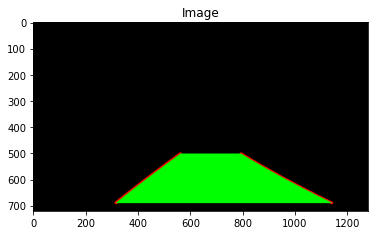

In [35]:
AdjustedAllPointsCurved = np.hstack((LeftPointsCurve, np.flip(RightPointsCurve,1)))
cv2.fillPoly(LanesDrawn2, pts = [AdjustedAllPointsCurved] ,color=(0, 255, 0))
show_image(LanesDrawn2)

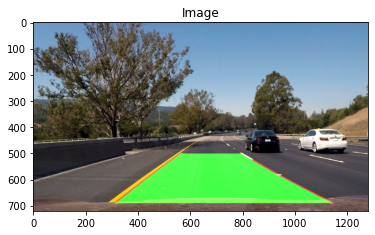

In [36]:
combine2 = cv2.addWeighted(images[image_idx],1, LanesDrawn2, 1,1)
show_image(combine2)

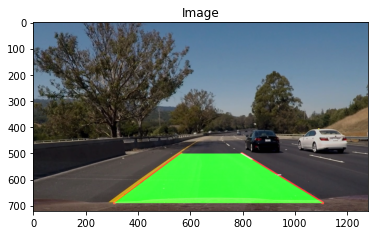

In [37]:
show_image(combine)

In [38]:
#Fits all points without calculating fit
# LeftPointsCurve2 = np.dstack((NewLeftX,NewLeftY))
# RightPointsCurve2 = np.dstack((NewRightX,NewRightY))
# LanesDrawn3 = DrawCurves(LeftPointsCurve2,RightPointsCurve2,sx_binary.shape[0],sx_binary.shape[1])
# combine3 = cv2.addWeighted(images[image_idx],1, LanesDrawn3, 1,1)
# show_image(combine3)

## Calculate Radius of Curvature

In [39]:
##
Radius_test =5 


## Displaying Radius of Curvature on Image

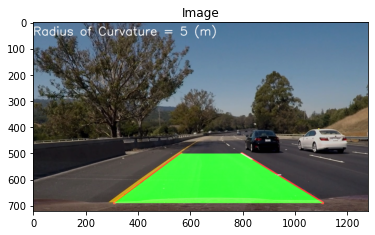

In [40]:
Radius_img=np.copy(combine)
cv2.putText(Radius_img, "Radius of Curvature = "+str(Radius_test) +" (m)", (0,50), 
            cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
show_image(Radius_img)

In [41]:
# ### This function returns the prespective and inverse prespective matrix for a prespective transform
# def perspectiveTransform(srcPoints, dstPoints):
#     M = cv2.getPerspectiveTransform(srcPoints, dstPoints)
#     Minv = cv2.getPerspectiveTransform(dstPoints, srcPoints)
#     return M, Minv
    
# ### This function applies prespective transform to an image and returns the warped image
# def warpPerspective(img, imgSize, M):
#     return cv2.warpPerspective(img, M, imgSize, cv2.INTER_LINEAR)

# srcPoints = getPolyPoints(sx_binary,900,100,80).astype(np.float32)

# dstPoints = np.array([[200, 700],
#                       [200, 50],
#                       [1000, 50],
#                       [1000, 700]]).astype(np.float32)

# M, Minv = perspectiveTransform(srcPoints, dstPoints)

# warped_image = warpPerspective(sx_binary, sx_binary.astype(np.float32).shape[1::-1], M)

# original_image = warpPerspective(warped_image, sx_binary.shape[1::-1], Minv)
# show_image(original_image)

In [42]:
# #detect lanes using hough

# def lane(image):
#     height = image.shape[0]
#     #polygons= np.array([[(200,height), (1100,height),(630,410)]])
#     polygons = getPolyPoints(image,1000,100,40)
#     mask = np.zeros_like(image)
#     cv2.fillPoly(mask,polygons,255)
#     #bitwise to show only whats in the mask
#     masked_img= cv2.bitwise_and(image, mask)
    
#     return masked_img

In [43]:
# # bitwise and operation mask and canny
# cropped_img = lane(sx_binary)
# show_image(cropped_img, "Cropped Image")

In [44]:
# def display_lines(img,lines):
#     line_image= np.zeros_like(image)
#     if lines is not None:
#         for line in lines:
#             x1, y1, x2, y2 = line.reshape(4)
#             cv2.line(line_image, (x1,y1), (x2,y2), (255, 0,0), 10)
            
#     return line_image

In [45]:
# #hough for straight lines
# #sufficiently small bins

# lines= cv2.HoughLinesP(cropped_img,2, np.pi/180, 120, np.array([]), minLineLength=1, maxLineGap=700)
# line_img= display_lines(lane_img, lines)
# show_image(line_img, "Lines Image")

In [46]:
# if lines is not None:
#     for line in lines:
#         print(line)

In [47]:
# May to fix detect lane
# Draw the polygon
# Connecting the lines
# Merging the video frames

## Making Video from frames

In [48]:
def makeVideo (frames,framePerSecond):
    video_name = 'Output Video.avi'
    height, width, layers = frames[0].shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc('M','J','P','G'), framePerSecond, (width,height))
    for i,frame in enumerate(frames):
        video.write(frame)
    video.release()

In [49]:
if (VideoFlag):
    makeVideo(frames,framePerSecond)